In [1]:
import pandas as pd
from db import Database
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')
import matplotlib.colors as mpcolors
import numpy as np

db = Database()

In [2]:

def get_df(db: Database, mwname, pcap_id, g: bool, pt: str, slot_h=1.0, nn=1, max_slots_h=0):

    if g:
        if pt == 'qr':
            where = 'rn_qr=1'
        elif pt == 'q':
            where = 'rn_qr=1 and is_r is false'
        elif pt == 'r':
            where = 'rn_qr=1 and is_r is true'
        elif pt == 'ok':
            where = 'is_r is true and rn_qr_rcode=1 and rcode = 0'
        elif pt == 'nx':
            where = 'is_r is true and rn_qr_rcode=1 and rcode = 3'
    else:
        if pt == 'qr':
            where='true'
        elif pt == 'q':
            where = 'is_r is false'
        elif pt == 'r':
            where = 'is_r is true'
        elif pt == 'ok':
            where = 'is_r is true and rcode = 0'
        elif pt == 'nx':
            where = 'is_r is true and rcode = 3'


    slot_seconds = 3600 * slot_h
    upper_where = ''
    if max_slots_h > 0:
        max_slots_time = max_slots_h/slot_h
        upper_where = f' and FLOOR(time_s_translated / {slot_seconds}) < {max_slots_time}'
        pass

    if pcap_id:
        df = pd.read_sql(f"""
        SELECT EPS{nn} < 0.5 AS pn, EPS{nn} >= 0.5 AS pp, time_s_translated, FLOOR(time_s_translated / {slot_seconds}) as "hour" from public.get_message_pcap_all3({pcap_id},0)
        where {where} {upper_where}
        """, db.engine)
    else:
        df = pd.read_sql(f"""
        SELECT EPS{nn} < 0.5 AS pn, EPS{nn} >= 0.5 AS pp, time_s_translated, FLOOR(time_s_translated / {slot_seconds}) as "hour" from public.get_message_healthy_all2()
        where {where} {upper_where}
        """, db.engine)

    df = df.groupby("hour").aggregate({"pn": "sum", "pp": 'sum'})

    df.index.name = 'slot'

    df.index = df.index - df.index.min()

    df = df.reindex(pd.Index(range(int(df.index.max()))), fill_value=0)

    df.index.name = 'slot'

    df = df.reset_index()

    if any(df.slot.value_counts() > 1):
        raise Exception('Some values are duplicated.')
    
    return df

In [3]:
dfh = get_df(db, 'healthy', None, True, 'nx', slot_h=1)
DFH = dfh[dfh.slot < 8].copy()
dfs = {
    'caphaw': get_df(db, 'caphaw', 54, True, 'nx', slot_h=1),
    'zbot': get_df(db, 'zbot', 46, True, 'nx', slot_h=1),
    'simda': get_df(db, 'simda', 58, True, 'nx', slot_h=1),
    'unknown': get_df(db, 'unknown', 57, True, 'nx', slot_h=1)
}
mws = list(dfs.keys())

In [29]:

negcolor = mpcolors.to_rgba((127/255, 127/255, 255/255, 1))
poscolor_1 = mpcolors.to_rgba((255/255, 127/255, 127/255, 0.8))
poscolor_2 = mpcolors.to_rgba((255/255, 67/255, 67/255, 0.8))
poscolor_3 = mpcolors.to_rgba((255/255, 33/255, 33/255, 0.8))
black = mpcolors.to_rgba((0, 0, 0, 0.5))

def capture(df, ax_n, ax_p):
    df = df.copy()


    df_count = (df['pp'] > 0).rolling(8).sum()
    df_max = df.rolling(8).max()
    df_mean = df.rolling(8).mean()

    num_slots = 50

    if num_slots:
        num_slots = num_slots if df.slot.max() > num_slots else df.slot.max()
        x0 = 0
        x0_rolled = x0 + 7
        df = df.iloc[x0:x0 + num_slots]
        df_max = df_max.iloc[x0_rolled:x0_rolled + num_slots]
        df_mean = df_mean.iloc[x0_rolled:x0_rolled + num_slots]
        df_count = df_count.iloc[x0_rolled:x0_rolled + num_slots]
        pass

    # ax_n.bar(df.index, df_max['pn'],  label='$\\eta^\\uparrow_\\kappa$', align='center', color=negcolor,    zorder=3)
    # ax_n.bar(df.index, df_mean['pn'], label='$\\eta^\\mu_\\kappa$',
    # align='center', color=black,       zorder=3)
    
    ax_n.bar(df.index, df_count, label='positive windows per group', align='center', color=negcolor,    zorder=3)

    ax_p.bar(df.index, df_max['pp'],  label='$\\rho^\\uparrow_\\kappa$', align='center', color=poscolor_2,  zorder=3)
    ax_p.bar(df.index, df_mean['pp'], label='$\\rho^\\mu_\\kappa$',  align='center', color=black,       zorder=3)

    ax_n.set_yticks(list(range(9)))
    ax_p.set_yticks([ int(t) for t in ax_p.get_yticks() ])

    # ax_n.set_xticks([ int(t) for t in range(0,50,5) ], [])
    # ax_p.set_xticks([ int(t) for t in range(0,50,5) ])

    ax_n.set_ylim(0, 8)
    ax_n.set_xlim(-2, 55)
    ax_p.set_xlim(-2, 55)

    # if df['pn'].max() == 0:
    #     ax_n.set_ylim(0,10)
    pass


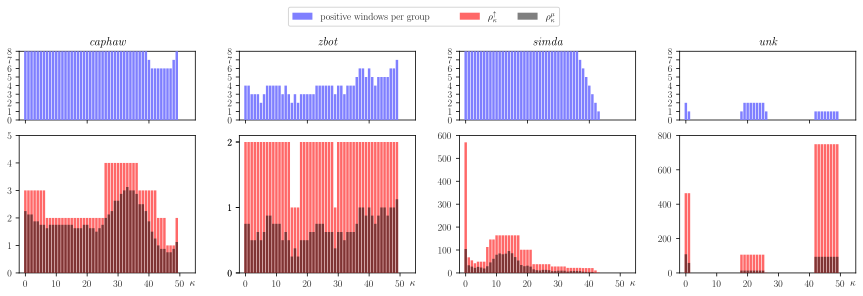

In [30]:

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "lmodern"
})

fig2 = plt.figure(figsize=( 15, 4 ))
gs2 = fig2.add_gridspec(2, 4, height_ratios=(0.5, 1), wspace=0.25, hspace=0.15)

for mwidx, mw in enumerate(mws):

    ax_pn = fig2.add_subplot(gs2[0, mwidx])
    ax_pp = fig2.add_subplot(gs2[1, mwidx])

    capture(dfs[mw], ax_pn, ax_pp)

    ax_pn.set_title(r'\textit{%s}' % mw.replace('nown', ''))
    ax_pn.set_xticklabels([])


    # if mwidx == 3:
    #     ax_pn.legend()
    #     ax_pp.legend()
    #     pass
    ax_pp.set_xlabel('$\\:\\:\\:\\kappa$', loc='right', labelpad=-10.)
    ax_pp.margins(x=.05)
    # ax_pp.text(0.5, -.2, '$\\alpha=8$', transform=ax_pp.transAxes, ha='center')

    ax_pp.set_xticks(list(range(0,60,10)))

    pass

h, l = [], []
[ (h.append(a[0]), l.append(a[1])) for ax in fig2.axes for a in list(zip(*ax.get_legend_handles_labels())) if a[1] not in l ]

fig2.legend(h, l, ncols=4, loc='center', bbox_to_anchor=(0.5, 1.0))

fig2.savefig('malicious_s.pdf', bbox_inches='tight')


In [124]:
dfss = {}

for idxmw, (mwname, mwid) in enumerate([('caphaw', 54), ('zbot', 46), ('simda', 58), ('unknown', 57)]):
    print(r'%s & $m_%s$' % (mwname, idxmw), end='')
    for g in [False, True]:
        for q in 'qr,q,r,ok,nx'.split(','):
            _hash = (mwname, mwid, g, q)
            if _hash not in dfs:
                dfss[_hash] = get_df(db, mwname, mwid, g, q, slot_h=1)
            df = dfss[_hash]
            df = df[df.slot <= 50]
            pp = df['pp'].sum() + df['pn'].sum()
            print(f' & {pp:4}', end='')
            pass
    print(' \\\\')

print([ f'${s}$' for s in 'qr,q,r,ok,nx'.split(',') ])

caphaw & $m_0$ & 2209 & 1105 & 1104 & 1104 &  220 &   28 &   14 &   14 &   14 &  111 \\
zbot & $m_1$ &  575 &  288 &  287 &  250 &   38 &  532 &  266 &  266 &  232 &   35 \\
simda & $m_2$ &   47 &   24 &   23 &   22 & 19872 &   18 &    9 &    9 &    8 & 1957 \\
unknown & $m_3$ &   33 &   17 &   16 &   16 & 2866 &    6 &    3 &    3 &    3 & 1729 \\
['$qr$', '$q$', '$r$', '$ok$', '$nx$']


In [123]:
print(' & '.join([ f'${s}$' for s in 'qr,q,r,ok,nx'.split(',') ]))

$qr$ & $q$ & $r$ & $ok$ & $nx$


In [ ]:
for idxmw, (mwname, mwid) in enumerate([('caphaw', 54), ('zbot', 46), ('simda', 58), ('unknown', 57)]):
    print(r'%s & $m_%s$' % (mwname, idxmw), end='')
    for g in [False, True]:
        for q in 'qr,q,r,ok,nx'.split(','):
            df = get_df(db, mwname, mwid, g, q, slot_h=1, max_slots_h=50)
            df = df[df.slot <= 50]
            pp = df['pp'].sum() + df['pn'].sum()
            print(f' & {pp:4}', end='')
            pass
    print(' \\\\')

In [102]:
df

,slot,pn,pp
0,0,3,464
1,1,0,482
2,2,0,0
3,3,0,0
4,4,0,0
...,...,...,...
166,166,0,0
167,167,0,0
168,168,0,0
169,169,0,0


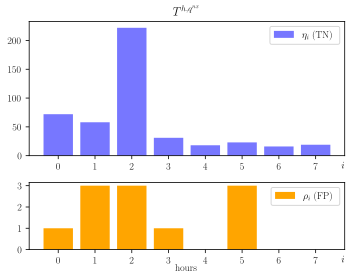

In [58]:


df = DFH.copy()

df['n'] = df['pn'] + df['pp']

fig2 = plt.figure(figsize=( 5, 4 ))
gs2 = fig2.add_gridspec(2, 1, height_ratios=(1, 0.5))

ax_n = fig2.add_subplot(gs2[0])
ax_p = fig2.add_subplot(gs2[1])

ax_n.bar(df.index, df['pn'], label='$\\eta_i$ (TN)', color=mpcolors.to_rgba('#0000FF88'),      zorder=3)
ax_p.bar(df.index, df['pp'], label='$\\rho_i$ (FP)', color='orange',   zorder=3)

ax_n.set_xlabel('$i$', loc='right', labelpad=-10.)
ax_p.set_xlabel('$i$', loc='right', labelpad=-10.)

ax_n.spines[:].set_zorder(4)
ax_p.spines[:].set_zorder(4)

ax_n.legend()
ax_p.legend()

ax_p.set_yticks(list(range(df['pp'].max() + 1)))

_ = ax_p.text(3.5, -1.0, 'hours', ha='center')

ax_n.set_title('$T^{h,q^{nx}}$')
fig2.tight_layout()
fig2.savefig('healthy.pdf')
